# Pairs Trading Implementation

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import seaborn as sns

import Quandl

# import statsmodels.api as sm
# from scipy import stats
# from statsmodels.graphics.api import qqplot
# from statsmodels.graphics import tsaplots

In [3]:
%matplotlib inline
plt.style.use('bmh');
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 'axes.facecolor': '0.9', 'grid.color': '.82'})

In [34]:
def get_adj_close(tickers, start="", end="", ratio=True):
    """
    Returns DataFrame with the adjusted close values for the 
        tickers passed in during the time frame specified
    """
    
    result = {}
    
    for ticker in tickers:
        try:
            result[ticker] = Quandl.get("WIKI/"+ticker, trim_start=start, trim_end=end)['Adj. Close']
        except DatasetNotFound:
            print(ticker, 'is not a vaild ticker')
            return
    
    if ratio:
        if result[tickers[0]].mean() > result[tickers[1]].mean():
            result[tickers[0]+'/'+tickers[1]] = result[tickers[0]]/result[tickers[1]]
        else:
            result[tickers[1]+'/'+tickers[0]] = result[tickers[1]]/result[tickers[0]]
    
    return pd.DataFrame(result).dropna()

In [35]:
cell = get_adj_close(['T', 'VZ'], start="1995-01-01")
#bev = get_adj_close(['PEP', 'KO'], start="1995-01-01")

In [21]:
assert cell.isnull().sum().all() == 0
assert bev.isnull().sum().all() == 0

In [38]:
#bev.head()

In [37]:
cell.head()

,T,VZ,VZ/T
Date,,,
1995-01-03,8.755044,12.311591,1.406228
1995-01-04,8.663981,12.143038,1.401554
1995-01-05,8.798272,12.111070,1.376528
1995-01-06,8.798272,12.049593,1.369541
1995-01-09,8.772281,12.049593,1.373599


In [28]:
def plot_pair(df, names):
    """
    Plot pair series with name subsitutions
    """
    tick1 = df.columns[0]
    tick2 = df.columns[1]
    
    fig, ax = plt.subplots(figsize=(20,8));
    years = YearLocator();
    yearsFmt = DateFormatter('%Y');
    
    ax.xaxis.set_major_locator(years);
    ax.xaxis.set_major_formatter(yearsFmt);
    ax.autoscale_view();
    
    plt.title(names[tick1] + ' and ' + 
              names[tick2] +' (Adj. Close)', fontsize=20);
    plt.ylabel('Adj. Close', fontsize=15);
    plt.xlabel('Time', fontsize=15);
    
    ax.plot_date(df.index, df[tick1], 'indianred', label=names[tick1]);
    ax.plot_date(df.index, df[tick2], 'steelblue', label=names[tick2]);
    
    plt.legend(loc=2, prop={'size':15}, frameon=True);

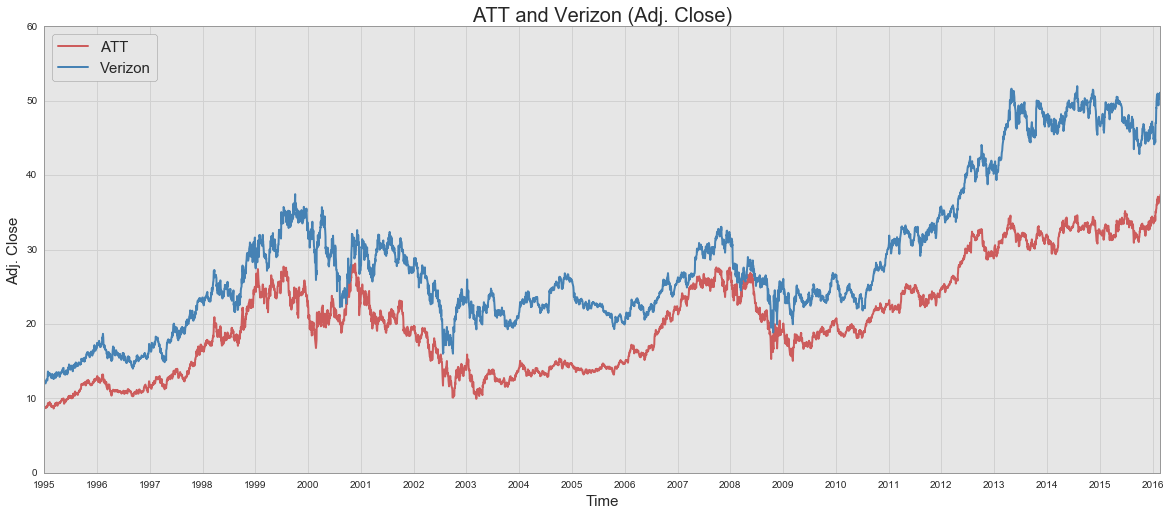

In [30]:
plot_pair(cell, {'T':'ATT', 'VZ':'Verizon'})

In [107]:
a = [1]

In [108]:
if a:
    print('a')

a


In [39]:
#plot_pair(bev, {'KO':'Coke', 'PEP':'Pepsi'})

In [166]:
def plot_ratio(ratio, name, deviations=[1], positions=[]):
    fig = plt.subplots(figsize=(20,8));

    plt.title('Ratio ' + name + ' Adjusted Close', fontsize=20);
    plt.ylabel('Ratio', fontsize=15);
    plt.xlabel('Time Index', fontsize=15);
    plt.xlim([0,ratio.size])
    plt.xticks(np.arange(0, ratio.size, 500))
    
    plt.plot(np.arange(ratio.size), ratio, 'black', label='Ratio', alpha=0.5);
    plt.plot([0, ratio.size], [ratio.mean(), ratio.mean()], 'steelblue', lw=2, label='Mean');
    
    for color, std in zip(['y','orange','salmon','red'], deviations):
        plt.plot([0, ratio.size], [ratio.mean()-std*ratio.std(), ratio.mean()-std*ratio.std()], 
                 '--', lw=2, label=str(std)+' STD', color=color);
        plt.plot([0, ratio.size], [ratio.mean()+std*ratio.std(), ratio.mean()+std*ratio.std()], 
                 '--', lw=2, color=color);
    
    if positions:
        opening_days, closing_days = [], []
        opening_ratios, closing_ratios = [], []
        
        for position in positions:
            opening_days.append(position['open'])
            closing_days.append(position['close'])
            opening_ratios.append(ratio.ix[position['open']])
            closing_ratios.append(ratio.ix[position['close']])
            
        plt.scatter(x=opening_days, y=opening_ratios, s=300, color='lime', edgecolor='black')
        plt.scatter(x=closing_days, y=closing_ratios, s=300, color='red', edgecolor='black')
    
    plt.legend(loc=1, prop={'size':15}, frameon=True);

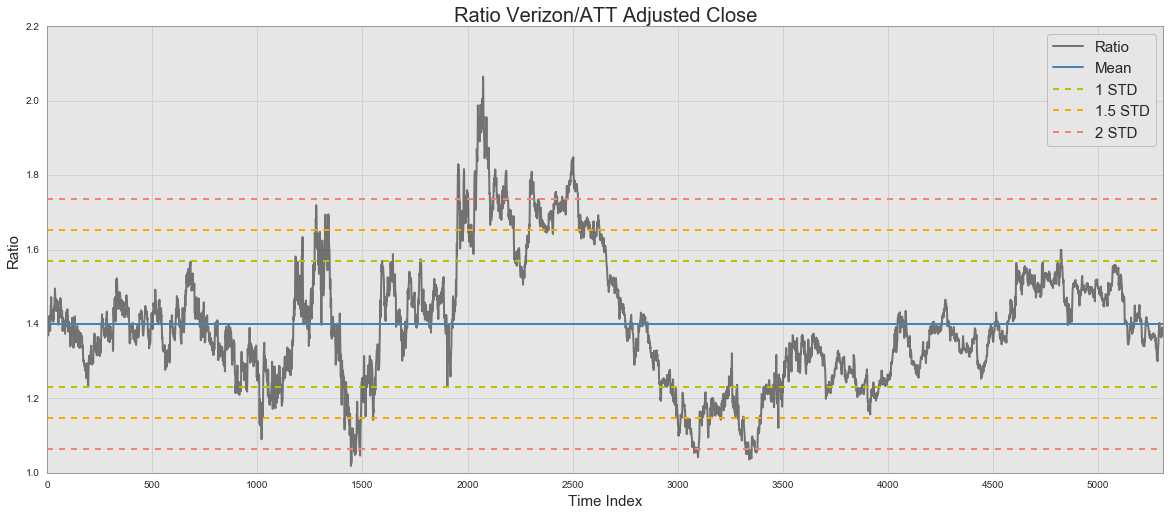

In [168]:
plot_ratio(cell['VZ/T'], name='Verizon/ATT', deviations=[1,1.5,2])

In [61]:
# fig = plt.figure(figsize=(20,10))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(avg_adj_close.dropna().values.squeeze(), lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(avg_adj_close.dropna().values, lags=40, ax=ax2)

In [62]:
# def moving_average(ts, theta1):
#     ma = pd.Series(index=ts.index, data=np.repeat(0, ts.size))
#     ma[0] = ts[0]
    
#     for idx in range(1,ts.size):
#         ma[idx] = theta1*ts[idx-1]
        
#     return ma

In [199]:
def identify_next_position(ratio, k, start=0):
    result = {}
    mean, sd = ratio.mean(), ratio.std()
    day, size = start, ratio.size
    
    while day < size:
        
        if ratio.ix[day] > mean + k*sd:
            result['open'] = day
            day += 1
            
            while day < size:
                if ratio.ix[day] <= mean:
                    result['close'] = day
                    return result
                day += 1
        
        elif ratio.ix[day] < mean - k*sd:
            result['open'] = day
            day += 1
            
            while day < size:
                if ratio.ix[day] >= mean:
                    result['close'] = day
                    return result
                day += 1
                
        day += 1
        
    return None

In [200]:
identify_next_position(cell['VZ/T'], 1)

{'close': 1171, 'open': 896}

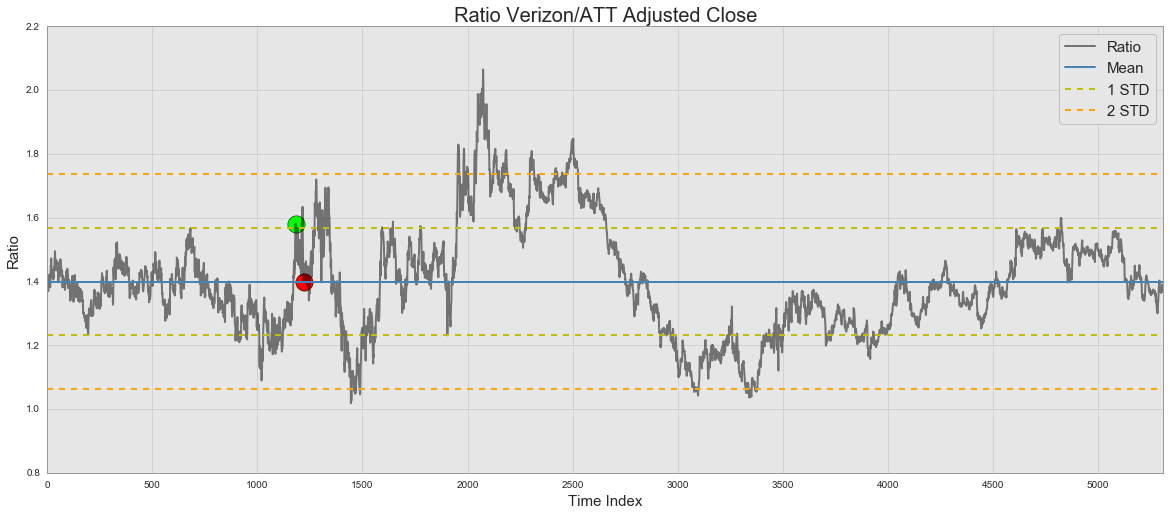

In [167]:
plot_ratio(cell['VZ/T'], 'Verizon/ATT', deviations=[1,2], positions=[identify_next_position(cell['VZ/T'], 1, 1171)])

In [201]:
def identify_all_positions(ratio, k, start=0):
    positions = []
    day, size = start, ratio.size
    
    while day < size:
        position = identify_next_position(ratio, k, day)
        
        if position:
            positions.append(position)
            day = position['close']
        else:
            break
    
    return positions

In [202]:
identify_all_positions(cell['VZ/T'], 1)

[{'close': 1171, 'open': 896},
 {'close': 1220, 'open': 1182},
 {'close': 1305, 'open': 1273},
 {'close': 1352, 'open': 1309},
 {'close': 1584, 'open': 1401},
 {'close': 1660, 'open': 1594},
 {'close': 1818, 'open': 1776},
 {'close': 1910, 'open': 1904},
 {'close': 2752, 'open': 1948},
 {'close': 4047, 'open': 2917},
 {'close': 4856, 'open': 4822}]

In [203]:
positions = identify_all_positions(cell['VZ/T'], 1)

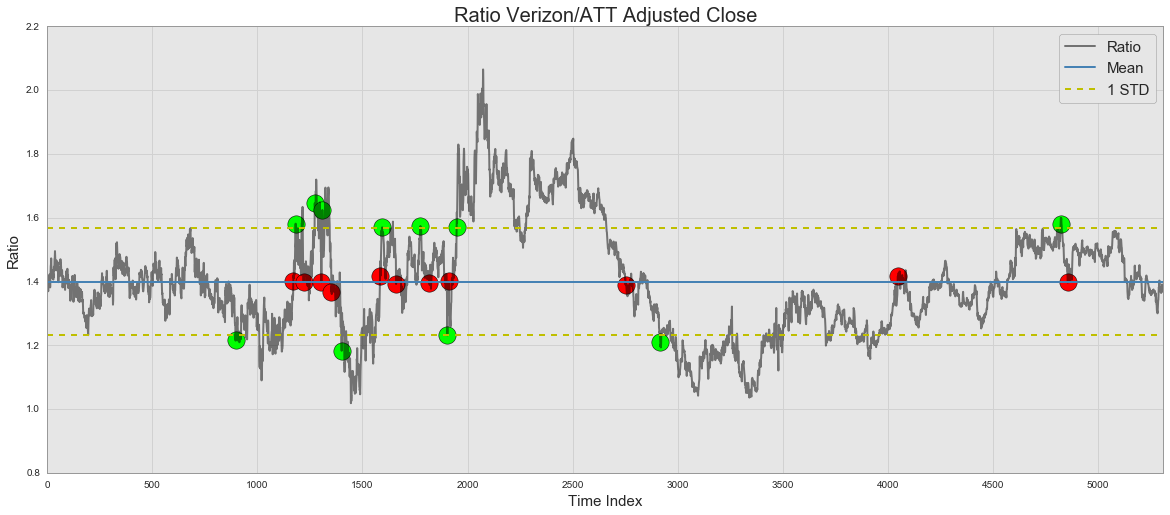

In [204]:
plot_ratio(cell['VZ/T'], 'Verizon/ATT', deviations=[1], positions=positions)